# TPE for Hyperparameter Tuning

In [1]:
# load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile
import urllib.request
import io
import warnings
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
warnings.filterwarnings('ignore')
#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from hyperopt import fmin, tpe, hp, Trials

In [2]:
# load processed data
train = pd.read_csv('https://github.com/zxyao5148/STAT3612_2023_1A_GroupProject/raw/main/data_processing/train/train_valid_latest.csv')

In [3]:
# separate response and features
X_train = train.drop(train.columns[0:9], axis=1)
y_train = train["readmitted_within_30days"]

In [5]:
#import sys
#sys.path.append('../code_base') # relative path to code base
#from adjust_imbl import adjust_imbl
#X_train, y_train = adjust_imbl(X_train, y_train)

Original dataset shape Counter({0: 9564, 1: 2032})
Resampled dataset shape Counter({0: 9564, 1: 9564})


In [14]:
# logistic regression
def lr_objt_fun(args):
    C, penalty = args
    lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear', random_state=42)
    score = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score  
space = [
    hp.loguniform('C', np.log(0.001), np.log(100)),  
    hp.choice('penalty', ['l1','l2']) 
]
trials = Trials()
best = fmin(fn=lr_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [12:51<00:00,  7.71s/trial, best loss: -0.7490541459102877]
{'C': 0.14424225684940264, 'penalty': 0}


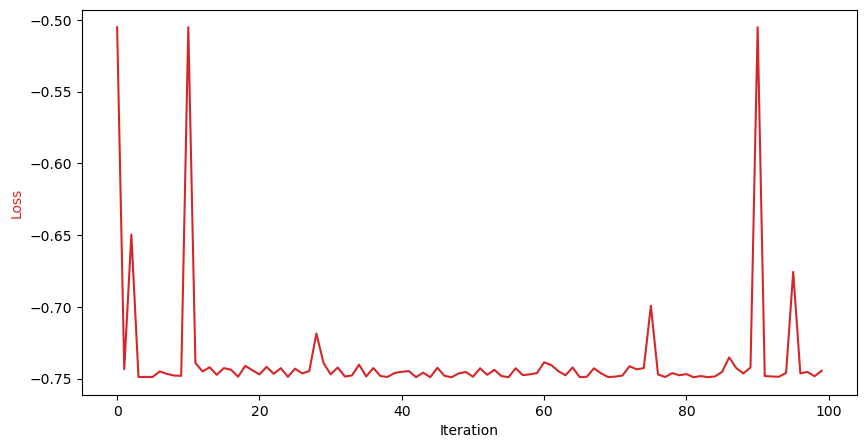

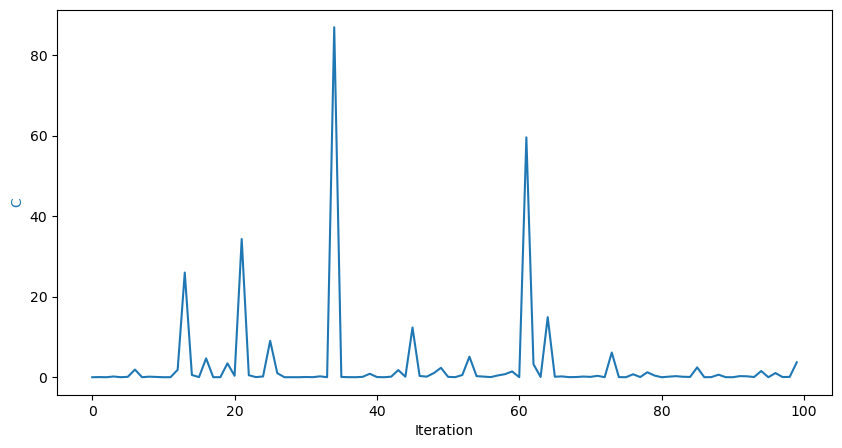

In [16]:
# visualize LR parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
Cs = [trial['misc']['vals']['C'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('C', color='tab:blue')
axs[1].plot(Cs, color='tab:blue')

plt.show()

In [17]:
# Linear Discriminant Analysis
def lda_objt_fun(args):
    shrinkage = args
    lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=shrinkage)
    score = cross_val_score(lda, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = hp.uniform('shrinkage', 0, 1)
trials = Trials()
best = fmin(fn=lda_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [06:46<00:00,  4.07s/trial, best loss: -0.7508139707217948]
{'shrinkage': 0.14310706696422165}


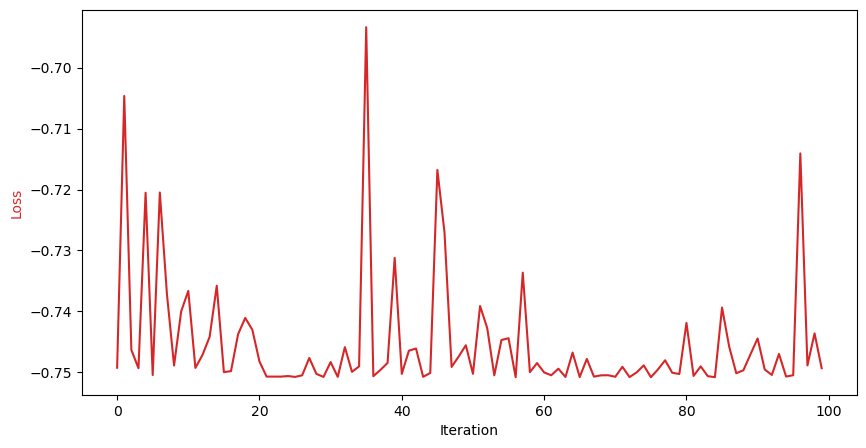

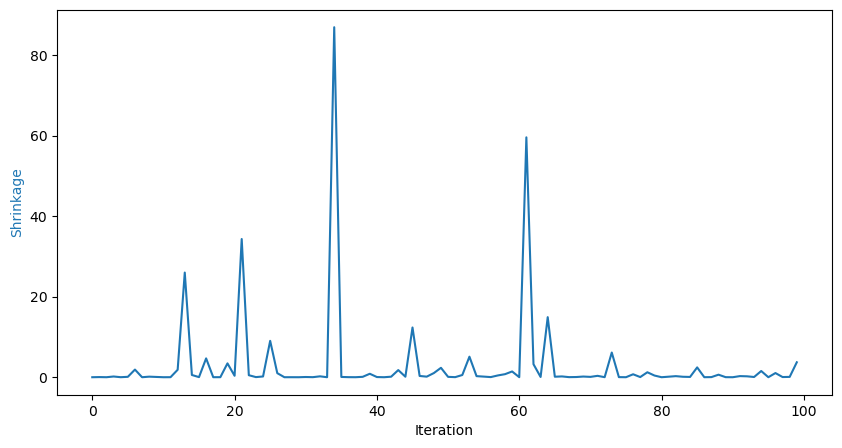

In [18]:
# visualize LDA parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
shrinkages = [trial['misc']['vals']['shrinkage'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Shrinkage', color='tab:blue')
axs[1].plot(Cs, color='tab:blue')

plt.show()

In [19]:
# Quadratic Discriminant Analysis
def qda_objt_fun(args):
    reg_param = args
    qda = QuadraticDiscriminantAnalysis(reg_param=reg_param)
    score = cross_val_score(qda, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = hp.uniform('reg_param', 0, 1)
trials = Trials()
best = fmin(fn=qda_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [11:09<00:00,  6.70s/trial, best loss: -0.708007068086936]
{'reg_param': 0.02816280355622438}


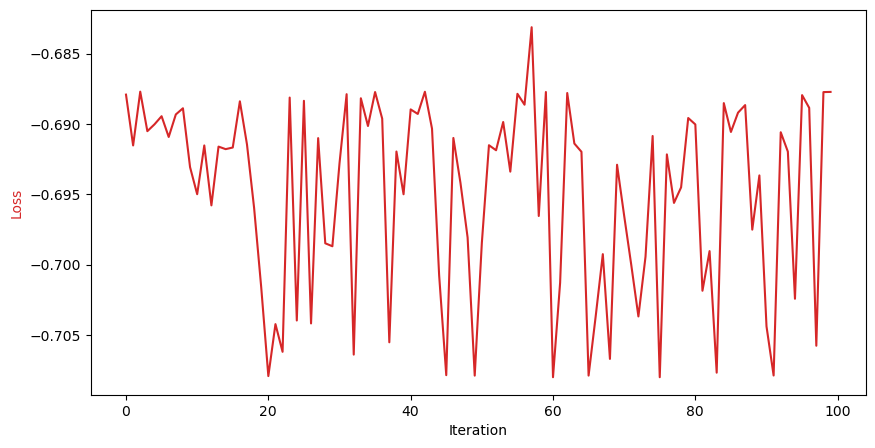

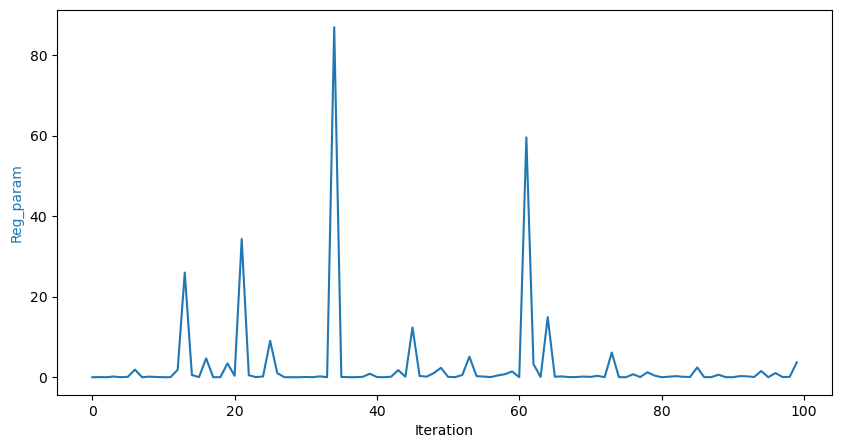

In [20]:
# visualize QDA parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
reg_params = [trial['misc']['vals']['reg_param'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Reg_param', color='tab:blue')
axs[1].plot(Cs, color='tab:blue')

plt.show()

In [21]:
# Naive Bayes
def nb_objt_fun(args):
    var_smoothing = args
    nb = GaussianNB(var_smoothing=var_smoothing)
    score = cross_val_score(nb, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = hp.uniform('var_smoothing', 0, 1)
trials = Trials()
best = fmin(fn=nb_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [00:12<00:00,  7.72trial/s, best loss: -0.6689244833615785]
{'var_smoothing': 0.016246366677565793}


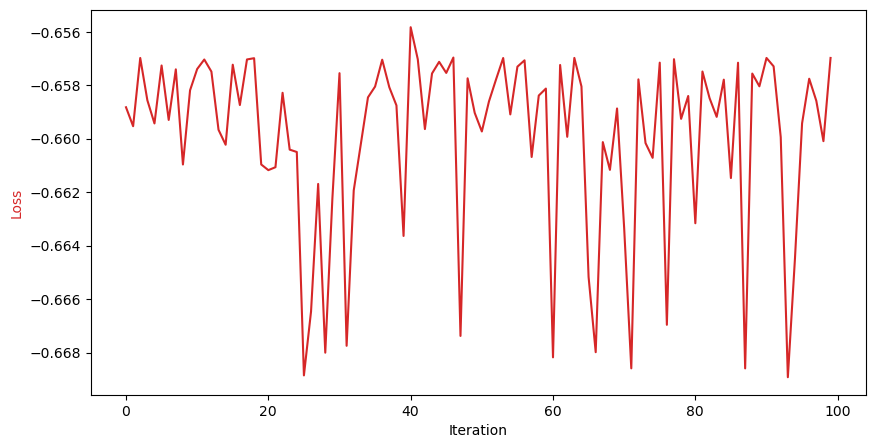

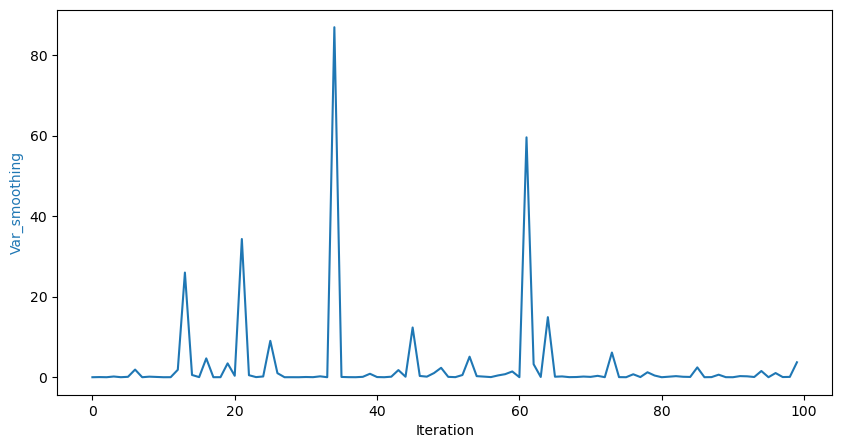

In [22]:
# visualize NB parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
var_smoothings = [trial['misc']['vals']['var_smoothing'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Var_smoothing', color='tab:blue')
axs[1].plot(Cs, color='tab:blue')

plt.show()

In [25]:
# K-Nearest Neighbors
def knn_objt_fun(args):
    n_neighbors, weights = args
    knn = KNeighborsClassifier(n_neighbors=int(n_neighbors), weights=weights)
    score = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.quniform('n_neighbors', 1, 100, 1), hp.choice('weights', ['uniform', 'distance'])]
trials = Trials()
best = fmin(fn=knn_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [02:43<00:00,  1.64s/trial, best loss: -0.7127066758781923]
{'n_neighbors': 72.0, 'weights': 1}


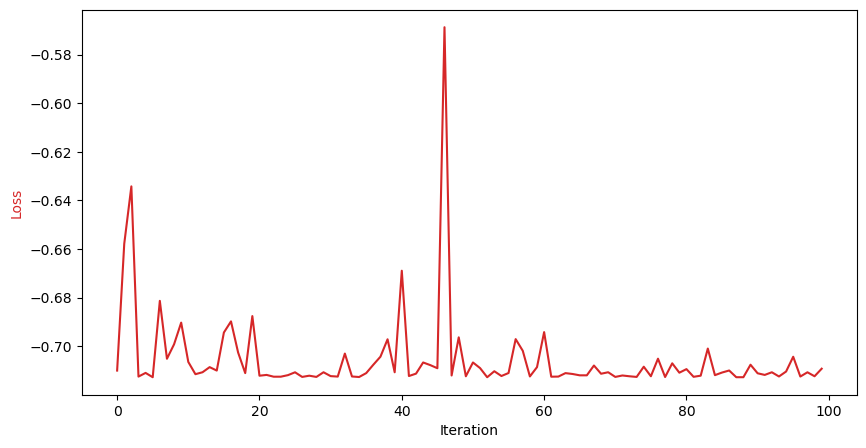

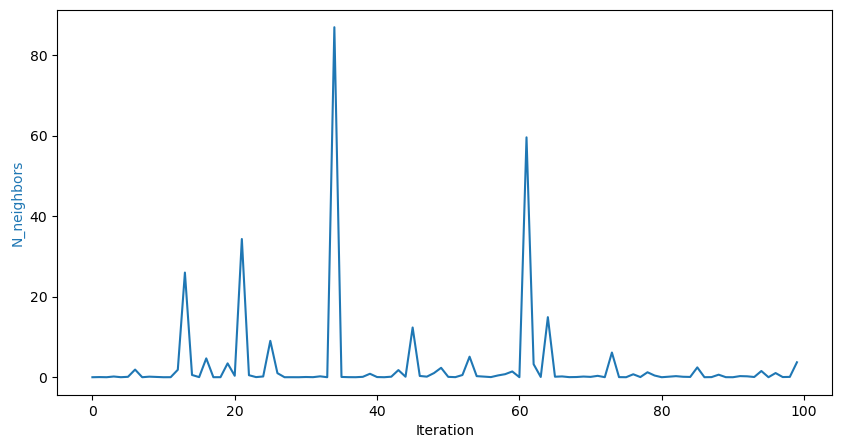

In [26]:
# visualize KNN parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
n_neighborss = [trial['misc']['vals']['n_neighbors'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('N_neighbors', color='tab:blue')
axs[1].plot(Cs, color='tab:blue')

plt.show()

In [49]:
# Support Vector Machine
def svm_objt_fun(args):
    C, gamma, kernel = args
    svm = SVC(C=C, gamma=gamma, kernel=kernel, probability=True)
    score = cross_val_score(svm, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.loguniform('C', np.log(0.001), np.log(100)), 
         hp.loguniform('gamma', np.log(0.001), np.log(100)), 
         hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])]
trials = Trials()
best = fmin(fn=svm_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

  1%|          | 1/100 [13:23<22:04:57, 803.00s/trial, best loss: -0.6488105116952305]

In [ ]:
# visualize SVM parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
Cs = [trial['misc']['vals']['C'][0] for trial in trials.trials]
gammas = [trial['misc']['vals']['gamma'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('C', color='tab:blue')
axs[1].plot(Cs, color='tab:blue')

axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Gamma', color='tab:green')
axs[2].plot(gammas, color='tab:green')

plt.show()

In [6]:
# Decision Tree
def dt_objt_fun(args):
    max_depth, min_samples_split, min_samples_leaf = args
    dt = DecisionTreeClassifier(max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=42)
    score = cross_val_score(dt, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.quniform('max_depth', 1, 100, 1), 
         hp.quniform('min_samples_split', 2, 100, 1), 
         hp.quniform('min_samples_leaf', 1, 100, 1)]
trials = Trials()
best = fmin(fn=dt_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [01:02<00:00,  1.60trial/s, best loss: -0.8986142385498536]
{'max_depth': 32.0, 'min_samples_leaf': 4.0, 'min_samples_split': 82.0}


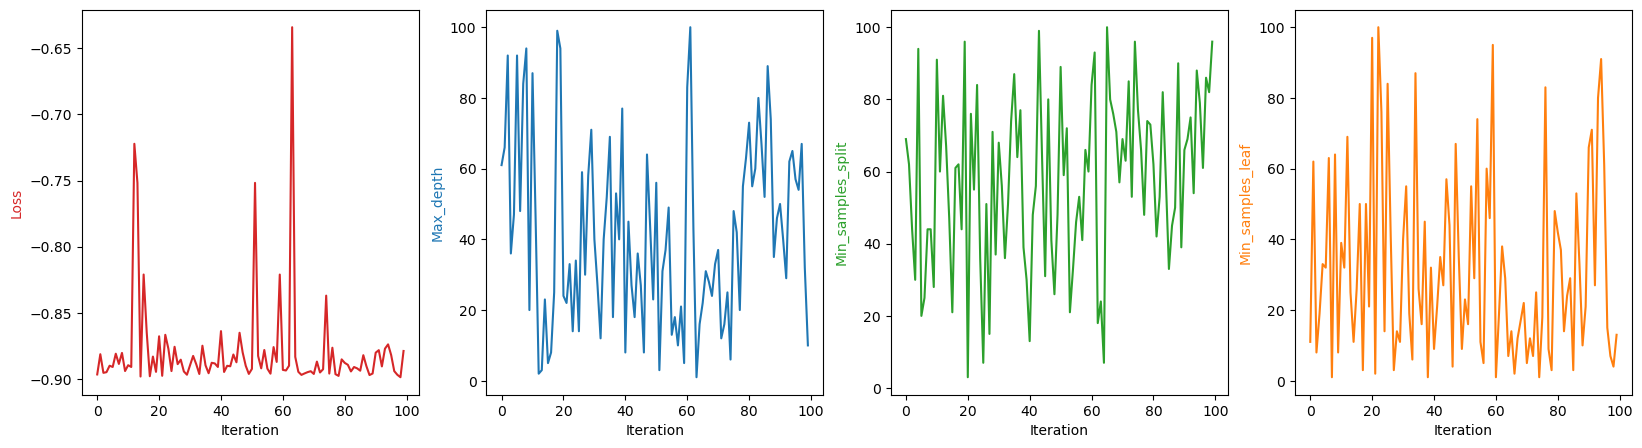

In [7]:
# visualize DT parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
max_depths = [trial['misc']['vals']['max_depth'][0] for trial in trials.trials]
min_samples_splits = [trial['misc']['vals']['min_samples_split'][0] for trial in trials.trials]
min_samples_leafs = [trial['misc']['vals']['min_samples_leaf'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Max_depth', color='tab:blue')
axs[1].plot(max_depths, color='tab:blue')

axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Min_samples_split', color='tab:green')
axs[2].plot(min_samples_splits, color='tab:green')

axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Min_samples_leaf', color='tab:orange')
axs[3].plot(min_samples_leafs, color='tab:orange')

plt.show()

In [36]:
# Bagging
def bag_objt_fun(args):
    n_estimators, max_samples, max_features = args
    bag = BaggingClassifier(n_estimators=int(n_estimators), max_samples=max_samples, max_features=max_features, random_state=42)
    score = cross_val_score(bag, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.quniform('n_estimators', 1, 100, 1), 
         hp.uniform('max_samples', 0, 1), 
         hp.uniform('max_features', 0, 1)]
trials = Trials()
best = fmin(fn=bag_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [18:24<00:00, 11.05s/trial, best loss: -0.7765529925930579]


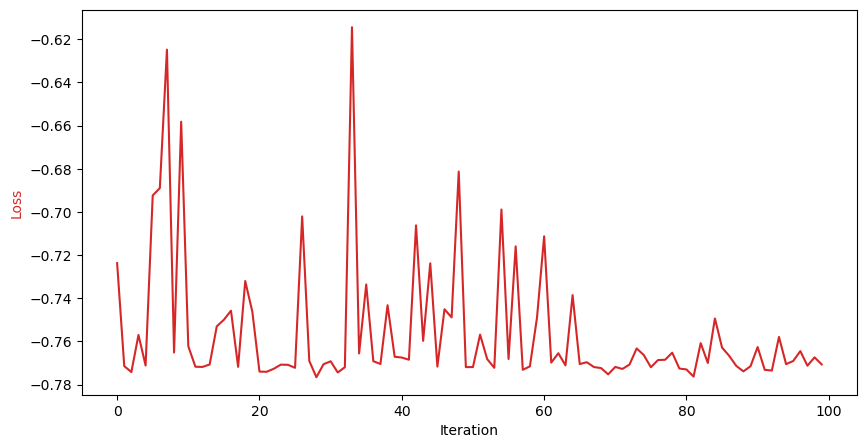

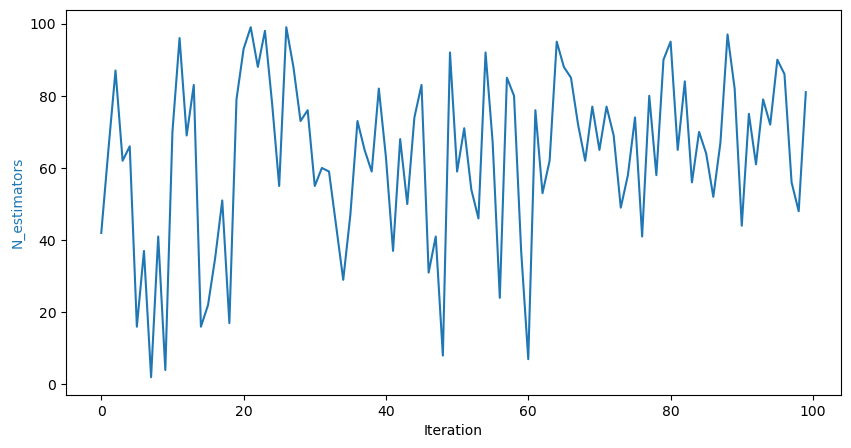

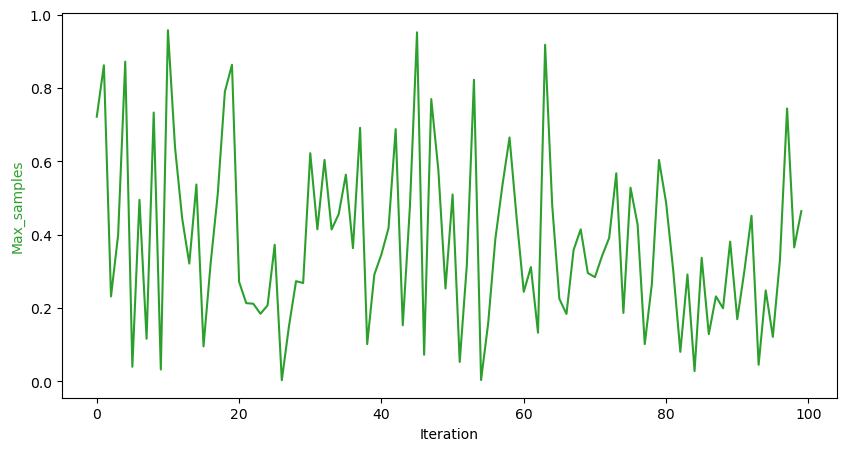

In [37]:
# visualize Bagging parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
n_estimatorss = [trial['misc']['vals']['n_estimators'][0] for trial in trials.trials]
max_sampless = [trial['misc']['vals']['max_samples'][0] for trial in trials.trials]
max_featuress = [trial['misc']['vals']['max_features'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('N_estimators', color='tab:blue')
axs[1].plot(n_estimatorss, color='tab:blue')

axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Max_samples', color='tab:green')
axs[2].plot(max_sampless, color='tab:green')

plt.show()

In [38]:
# Random Forest
def rf_objt_fun(args):
    n_estimators, max_depth, min_samples_split, min_samples_leaf = args
    rf = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=42)
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.quniform('n_estimators', 1, 100, 1), 
         hp.quniform('max_depth', 1, 100, 1), 
         hp.quniform('min_samples_split', 2, 100, 1), 
         hp.quniform('min_samples_leaf', 1, 100, 1)]
trials = Trials()
best = fmin(fn=rf_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [05:07<00:00,  3.07s/trial, best loss: -0.7873719798167436]
{'max_depth': 84.0, 'min_samples_leaf': 5.0, 'min_samples_split': 37.0, 'n_estimators': 87.0}


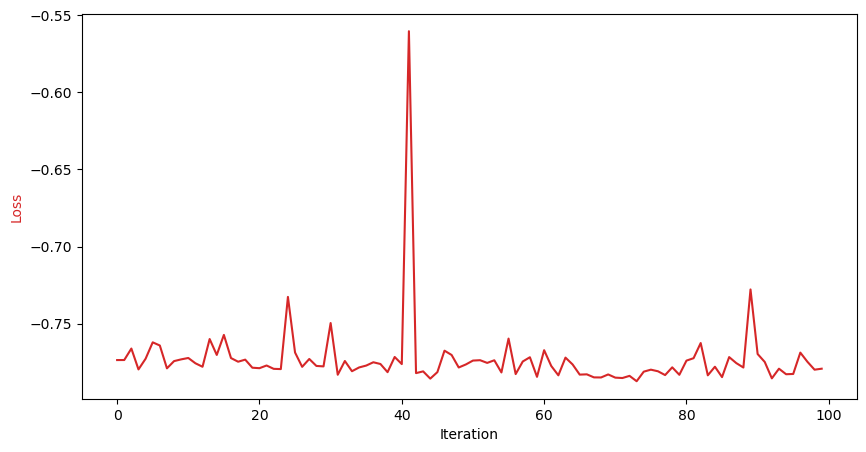

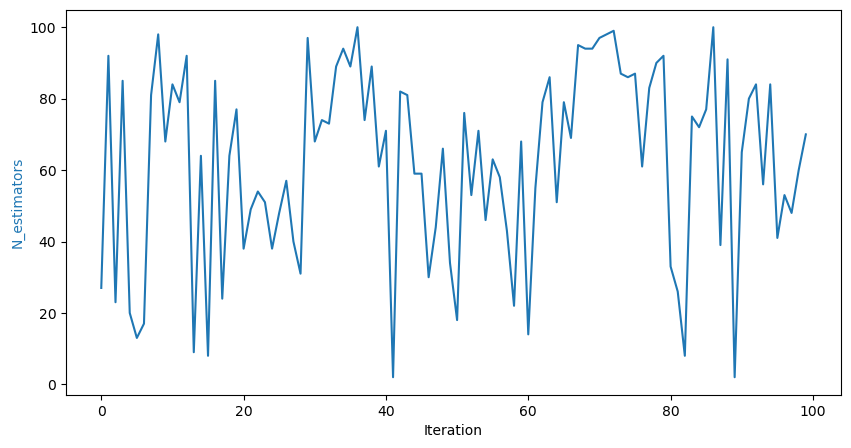

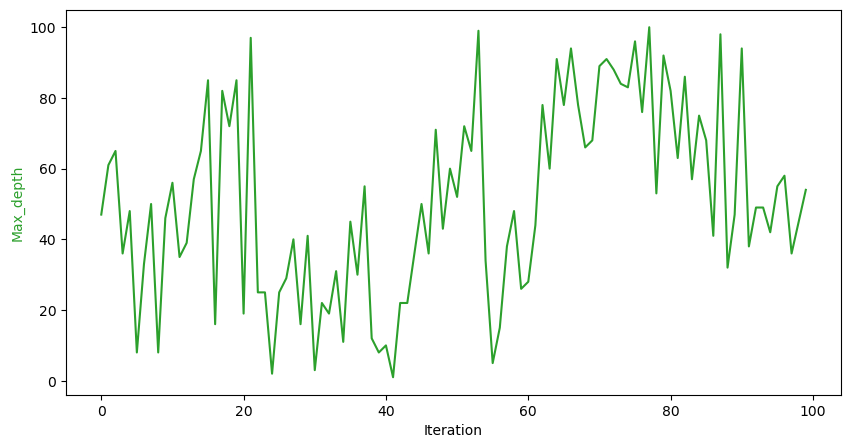

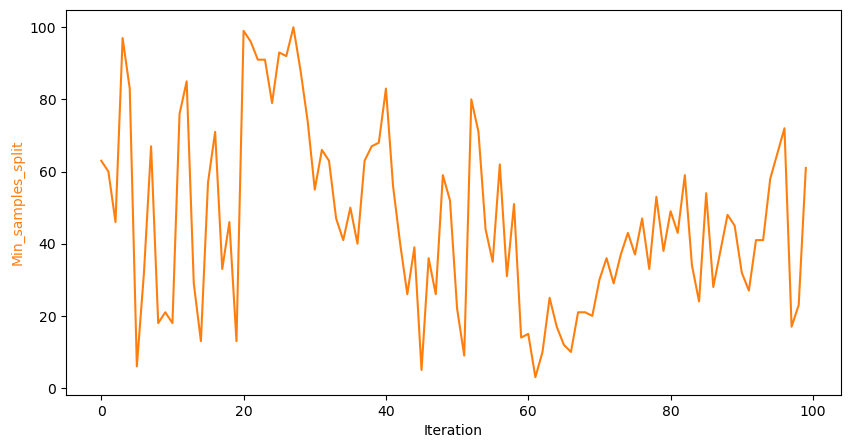

In [39]:
# visualize RF parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
n_estimatorss = [trial['misc']['vals']['n_estimators'][0] for trial in trials.trials]
max_depths = [trial['misc']['vals']['max_depth'][0] for trial in trials.trials]
min_samples_splits = [trial['misc']['vals']['min_samples_split'][0] for trial in trials.trials]
min_samples_leafs = [trial['misc']['vals']['min_samples_leaf'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('N_estimators', color='tab:blue')
axs[1].plot(n_estimatorss, color='tab:blue')

axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Max_depth', color='tab:green')
axs[2].plot(max_depths, color='tab:green')

axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Min_samples_split', color='tab:orange')
axs[3].plot(min_samples_splits, color='tab:orange')

plt.show()

In [47]:
# Gradient Boosting
def gb_objt_fun(args):
    n_estimators, learning_rate, max_depth, min_samples_split, min_samples_leaf = args
    gb = GradientBoostingClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=42)
    score = cross_val_score(gb, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.quniform('n_estimators', 1, 100, 1), 
         hp.uniform('learning_rate', 0, 1), 
         hp.quniform('max_depth', 1, 100, 1), 
         hp.quniform('min_samples_split', 2, 100, 1), 
         hp.quniform('min_samples_leaf', 1, 100, 1)]
trials = Trials()
best = fmin(fn=gb_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [13:03:35<00:00, 470.16s/trial, best loss: -0.7917408532506666]   
{'learning_rate': 0.03709836815262382, 'max_depth': 40.0, 'min_samples_leaf': 76.0, 'min_samples_split': 79.0, 'n_estimators': 99.0}


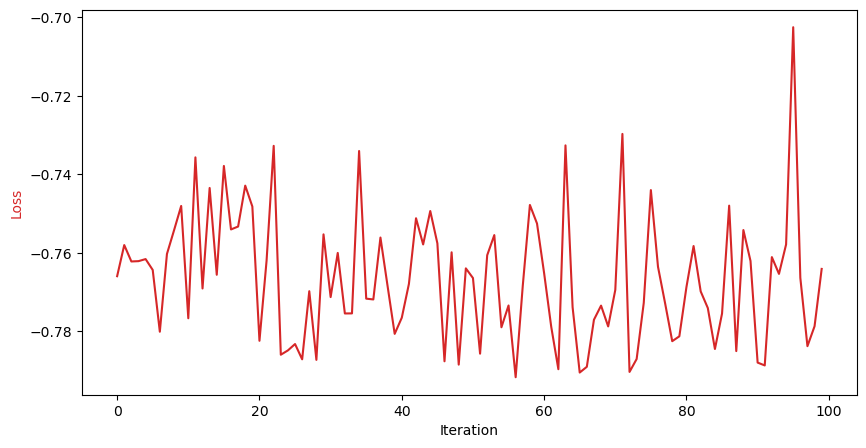

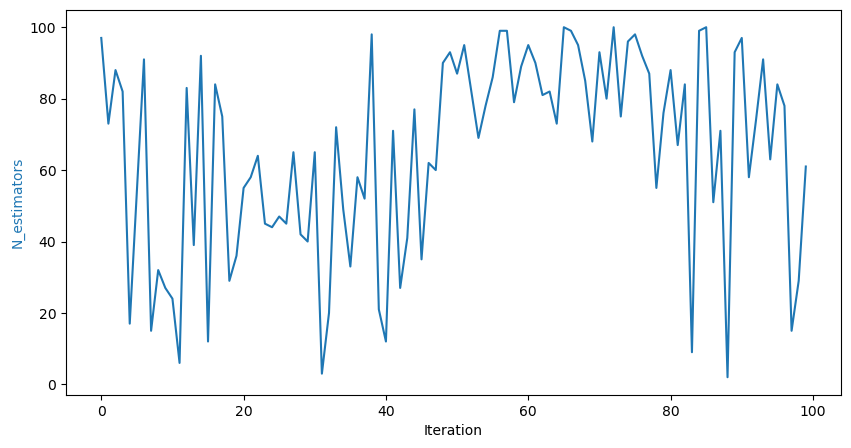

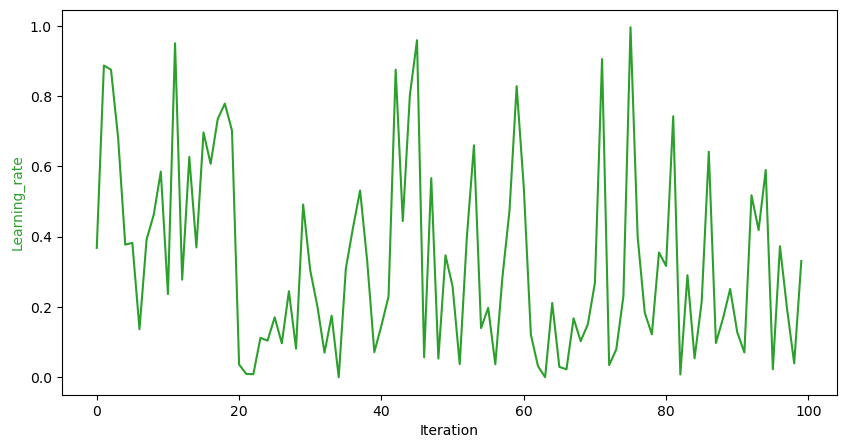

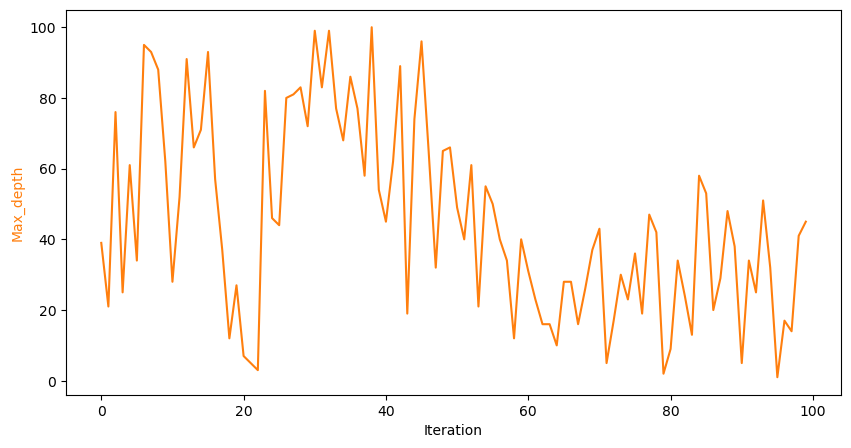

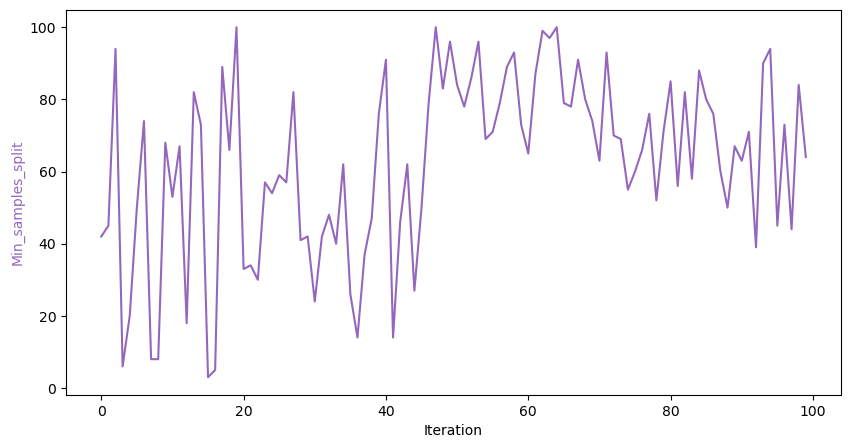

In [48]:
# visualize GB parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
n_estimatorss = [trial['misc']['vals']['n_estimators'][0] for trial in trials.trials]
learning_rates = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]
max_depths = [trial['misc']['vals']['max_depth'][0] for trial in trials.trials]
min_samples_splits = [trial['misc']['vals']['min_samples_split'][0] for trial in trials.trials]
min_samples_leafs = [trial['misc']['vals']['min_samples_leaf'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 5, figsize=(30, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('N_estimators', color='tab:blue')
axs[1].plot(n_estimatorss, color='tab:blue')

axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Learning_rate', color='tab:green')
axs[2].plot(learning_rates, color='tab:green')

axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Max_depth', color='tab:orange')
axs[3].plot(max_depths, color='tab:orange')

axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Min_samples_split', color='tab:purple')
axs[4].plot(min_samples_splits, color='tab:purple')

plt.show()

In [41]:
# AdaBoost
def ada_objt_fun(args):
    n_estimators, learning_rate = args
    ada = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
    score = cross_val_score(ada, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.quniform('n_estimators', 1, 100, 1), 
         hp.uniform('learning_rate', 0, 1)]
trials = Trials()
best = fmin(fn=ada_objt_fun, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
print(best)

100%|██████████| 100/100 [08:52<00:00,  5.32s/trial, best loss: -0.7646256797089585]
{'learning_rate': 0.35192648666402915, 'n_estimators': 82.0}


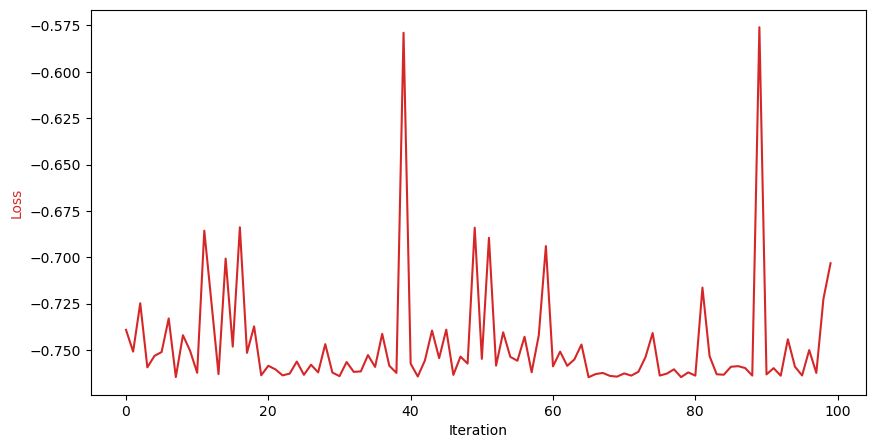

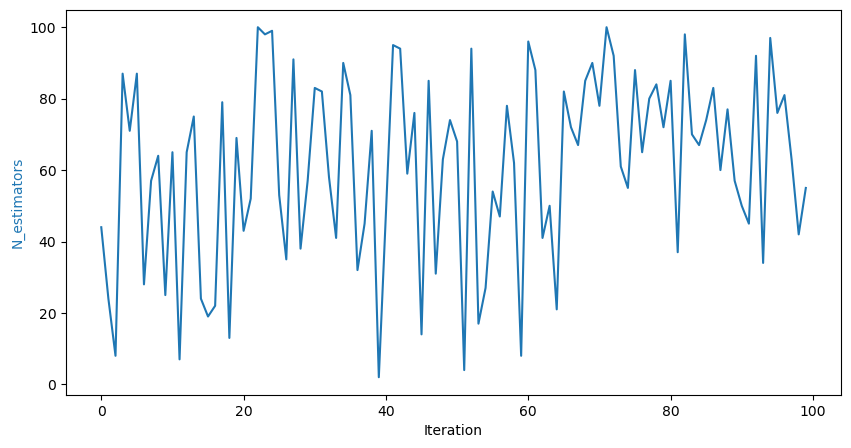

In [42]:
# visualize Ada parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
n_estimatorss = [trial['misc']['vals']['n_estimators'][0] for trial in trials.trials]
learning_rates = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('N_estimators', color='tab:blue')
axs[1].plot(n_estimatorss, color='tab:blue')

plt.show()

In [45]:
# XGBoost
def xgb_objt_fun(args):
    n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree = args
    xgb = XGBClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth), min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree, random_state=42)
    score = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return -score
space = [hp.quniform('n_estimators', 1, 100, 1), 
         hp.uniform('learning_rate', 0, 1), 
         hp.quniform('max_depth', 1, 100, 1), 
         hp.uniform('min_child_weight', 0, 1), 
         hp.uniform('gamma', 0, 1), 
         hp.uniform('subsample', 0, 1), 
         hp.uniform('colsample_bytree', 0, 1)]
trials = Trials()
best = fmin(fn=xgb_objt_fun, space=space, algo=tpe.suggest, max_evals=300, trials=trials)
print(best)

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 300/300 [15:26<00:00,  3.09s/trial, best loss: -0.791756101667126] 
{'colsample_bytree': 0.778272728435441, 'gamma': 0.33137928531283084, 'learning_rate': 0.022358832253819714, 'max_depth': 73.0, 'min_child_weight': 0.8563189938008136, 'n_estimators': 87.0, 'subsample': 0.5013815914012351}


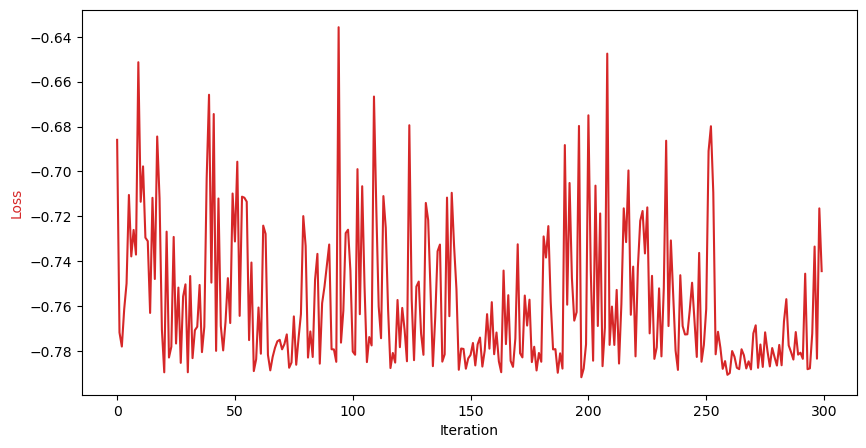

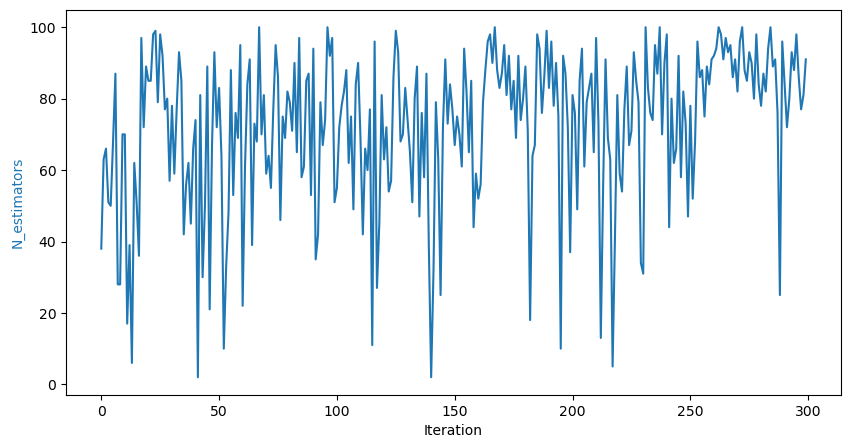

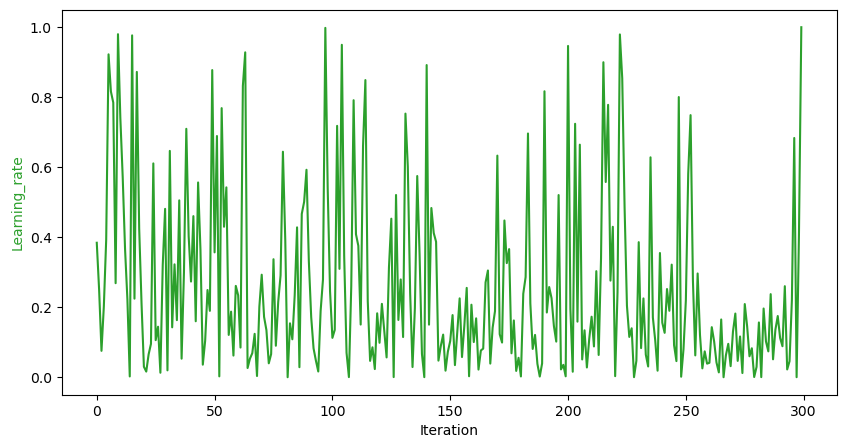

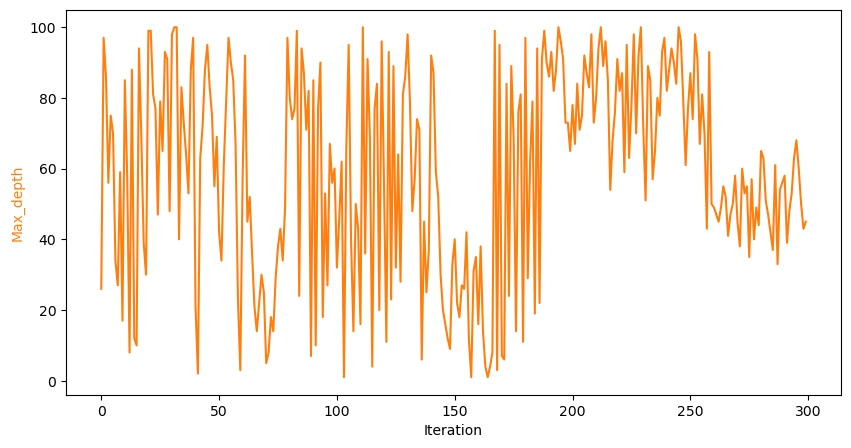

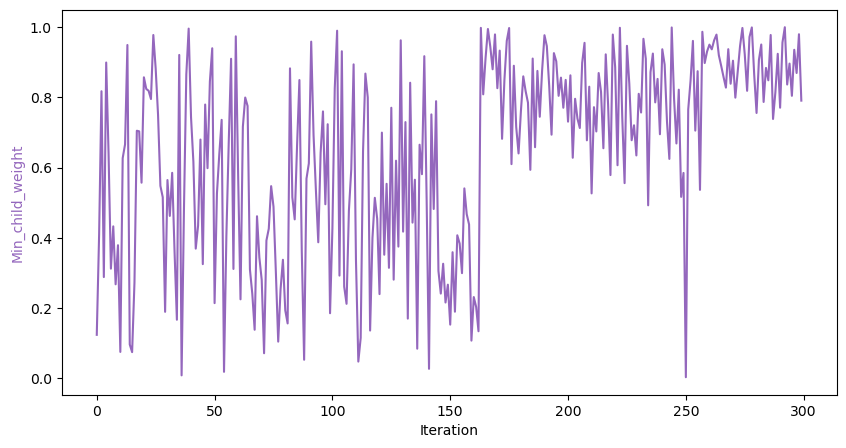

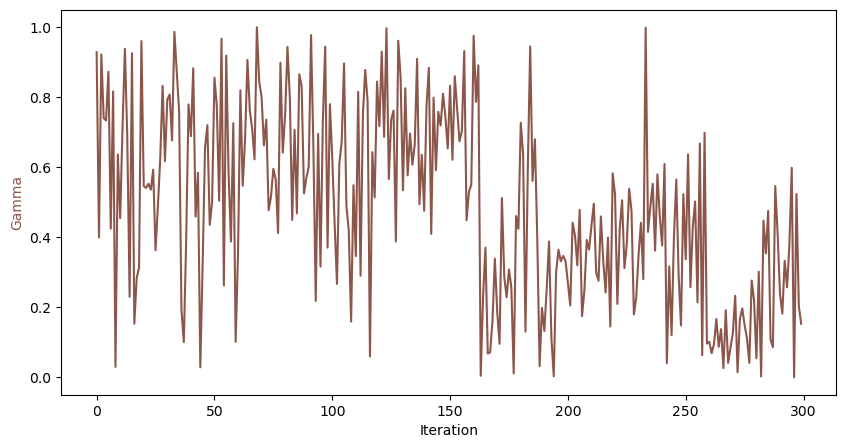

In [46]:
# visualize XGB parameter tuning
losses = [trial['result']['loss'] for trial in trials.trials]
n_estimatorss = [trial['misc']['vals']['n_estimators'][0] for trial in trials.trials]
learning_rates = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]
max_depths = [trial['misc']['vals']['max_depth'][0] for trial in trials.trials]
min_child_weights = [trial['misc']['vals']['min_child_weight'][0] for trial in trials.trials]
gammas = [trial['misc']['vals']['gamma'][0] for trial in trials.trials]
subsamples = [trial['misc']['vals']['subsample'][0] for trial in trials.trials]
colsample_bytrees = [trial['misc']['vals']['colsample_bytree'][0] for trial in trials.trials]

fig, axs = plt.subplots(1, 7, figsize=(30, 5))
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss', color='tab:red')
axs[0].plot(losses, color='tab:red')

axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('N_estimators', color='tab:blue')
axs[1].plot(n_estimatorss, color='tab:blue')

axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Learning_rate', color='tab:green')
axs[2].plot(learning_rates, color='tab:green')

axs[3].set_xlabel('Iteration')
axs[3].set_ylabel('Max_depth', color='tab:orange')
axs[3].plot(max_depths, color='tab:orange')

axs[4].set_xlabel('Iteration')
axs[4].set_ylabel('Min_child_weight', color='tab:purple')
axs[4].plot(min_child_weights, color='tab:purple')

axs[5].set_xlabel('Iteration')
axs[5].set_ylabel('Gamma', color='tab:brown')
axs[5].plot(gammas, color='tab:brown')

axs[6].set_xlabel('Iteration')
axs[6].set_ylabel('Colsample_bytree', color='tab:pink')
axs[6].plot(colsample_bytrees, color='tab:pink')

plt.show()